<a href="https://colab.research.google.com/github/Krystian3000/nft_price_prediciton/blob/main/arima_baseline_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**As we are in process of gathering the data, this notebook is to be seen only as a template for further experiments!**

# Install and import required packages

In [1]:
!pip install wandb

In [121]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error #mape error for one of our metrics + metrics for comparison between models
from sklearn.model_selection import TimeSeriesSplit
import wandb
from google.colab import userdata
from google.cloud import bigquery
import os
from pathlib import Path
import requests
import datetime as dt
import matplotlib.pyplot as plt

In [5]:
response = requests.get(f"https://raw.githubusercontent.com/Krystian3000/frontend/main/panelApps/nft-engineering-diploma-c933de618c2e.json?token=GHSAT0AAAAAACEDDV2HACZPSSQJIRAGWKXEZKKS3LQ", headers = {'Authorization': f'token {userdata.get("github_token")}'})

if response.status_code == 200:
    # If the request is successful, save the file locally
    with open("bigquery_secret.json", 'wb') as file:
        file.write(response.content)
    print("Successfully saved file")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")


Successfully saved file


In [6]:
#File with credentials must be copied into cwd for the time being -- to be automated;stored in gcp secrets
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.join(Path(os.getcwd()).resolve(), "bigquery_secret.json")

In [7]:
# Initialize W&B with your API key
wandb.login(key=userdata.get("wandb_api_key"))

wandb: Currently logged in as: krystian-opala. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Import data

In [8]:
def execute_query(query):
    # Create a BigQuery client
    client = bigquery.Client()

    # Create a context manager to ensure the connection is properly closed
    with client as bq_client:
        # Run the query
        query_job = bq_client.query(query)
        # Wait for the query to complete
        df = query_job.to_dataframe()

    client.close()
    del client

    return df

In [27]:
query = f"SELECT date_time, active_floor_price FROM `nft-engineering-diploma.opensea.active_listings_1m_aggregate` ORDER BY date_time"
df_raw = execute_query(query)

# EDA of dataset

In [28]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43197 entries, 0 to 43196
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   date_time           43197 non-null  datetime64[ns, UTC]
 1   active_floor_price  43197 non-null  object             
dtypes: datetime64[ns, UTC](1), object(1)
memory usage: 675.1+ KB


Wrong price data type - fixing

In [30]:
df = df_raw.rename(columns={'active_floor_price':'price'}).astype({"price":np.float16}).set_index('date_time').copy() #deepcopy to avoid inference

Info about the data

In [31]:
df.describe()

,price
count,43197.000000
mean,0.183960
std,0.047394
min,0.000000
25%,0.150024
50%,0.209961
75%,0.209961
max,0.300049


datetime range

In [70]:
datetime_range = df.reset_index()['date_time'].iloc[[0,-1]].values.tolist()
print(f"Start of datetime range: {pd.to_datetime(datetime_range[0])}")
print(f"End of datetime range: {pd.to_datetime(datetime_range[1])}")

Start of datetime range: 2017-06-24 00:04:00
End of datetime range: 2017-07-24 00:00:00


In [59]:
#Check if any missing data for given period
expected = df.iloc[[0,-1]].reset_index('date_time')['date_time'].diff().dt.total_seconds().values.tolist()[-1] / 60
assert expected + 1 == df.describe().loc['count'][0], "Wrong" # expected + 1 as inclusive range

Row number correct - no missing data

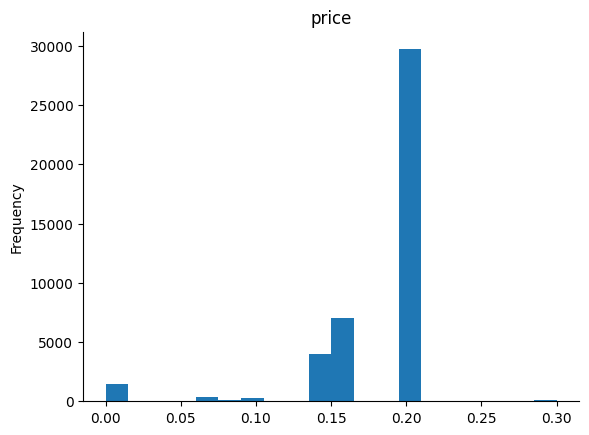

In [74]:
df['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

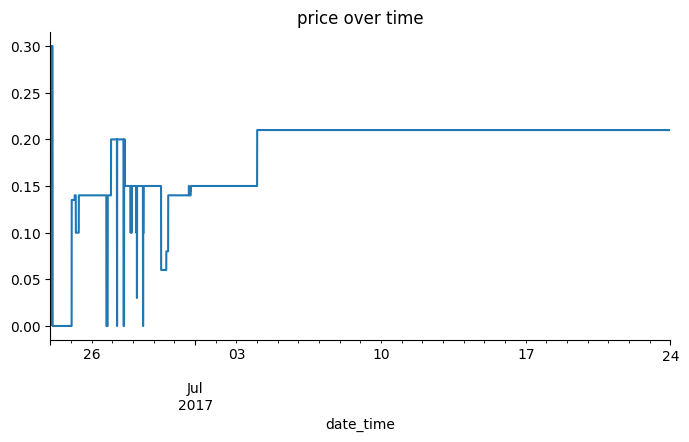

In [76]:
df['price'].plot(kind='line', figsize=(8, 4), title='price over time')
plt.gca().spines[['top', 'right']].set_visible(False)

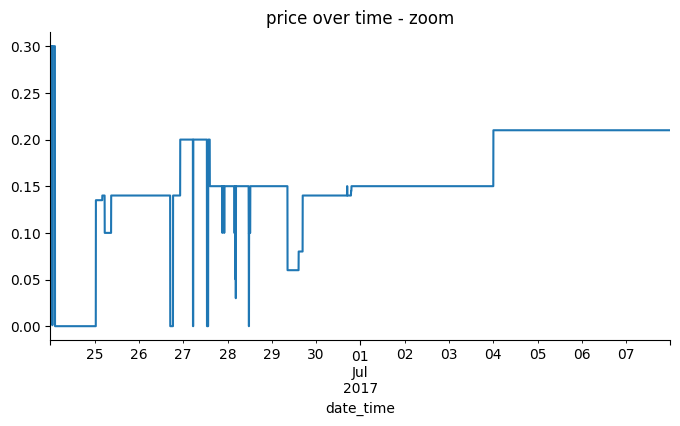

In [79]:
df_zoomed = df.loc[df.index < '2017-07-08 00:00:00', 'price'].copy()
df_zoomed.plot(kind='line', figsize=(8, 4), title='price over time - zoom')
plt.gca().spines[['top', 'right']].set_visible(False)

Despite lack of variability for big part of training set we'll try to fit the model to data


*   ARIMA may struggle to converge
*   Oversimplified model
*   ARIMA may not be capture sudden shifts (!!!)


**Longer period in the future / bigger aggregate windows**



*   Improved model stability
*   Potential information loss




# Looking at stationarity and ACF & PACF

<ipython-input-106-2275458fcd75>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(diff0.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)


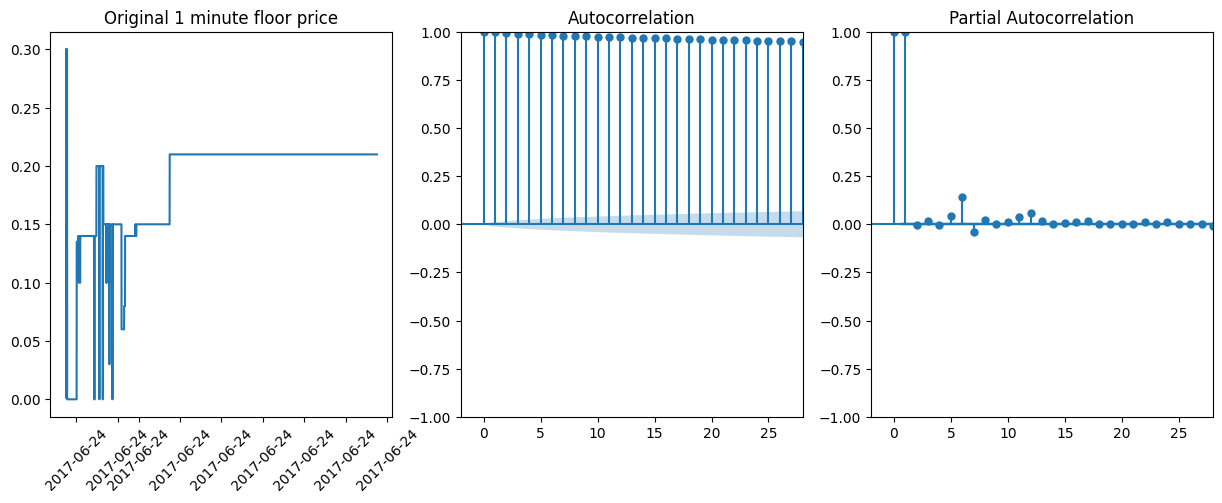

<ipython-input-106-2275458fcd75>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(diff1.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)


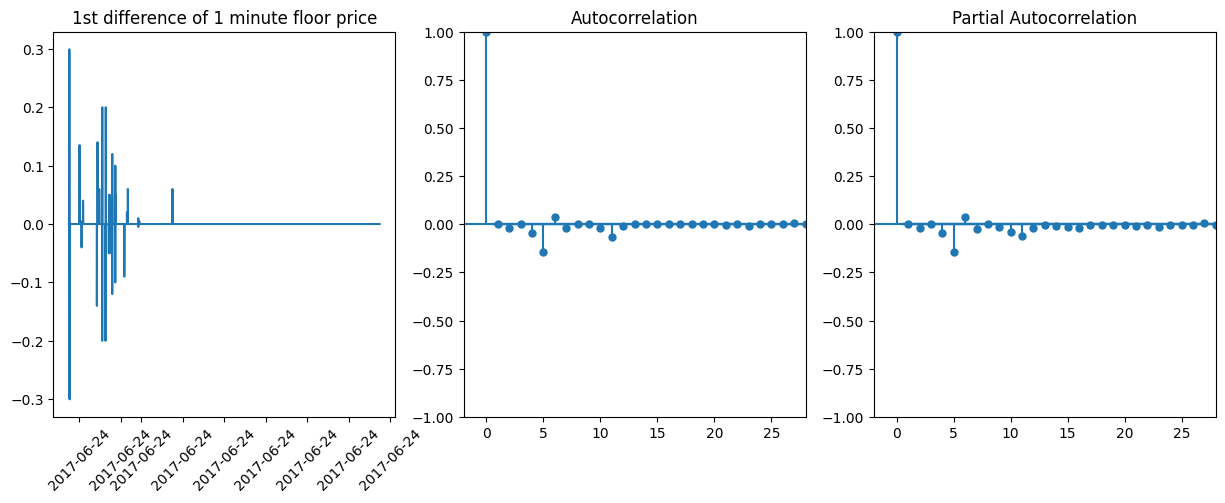

<ipython-input-106-2275458fcd75>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(diff2.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)


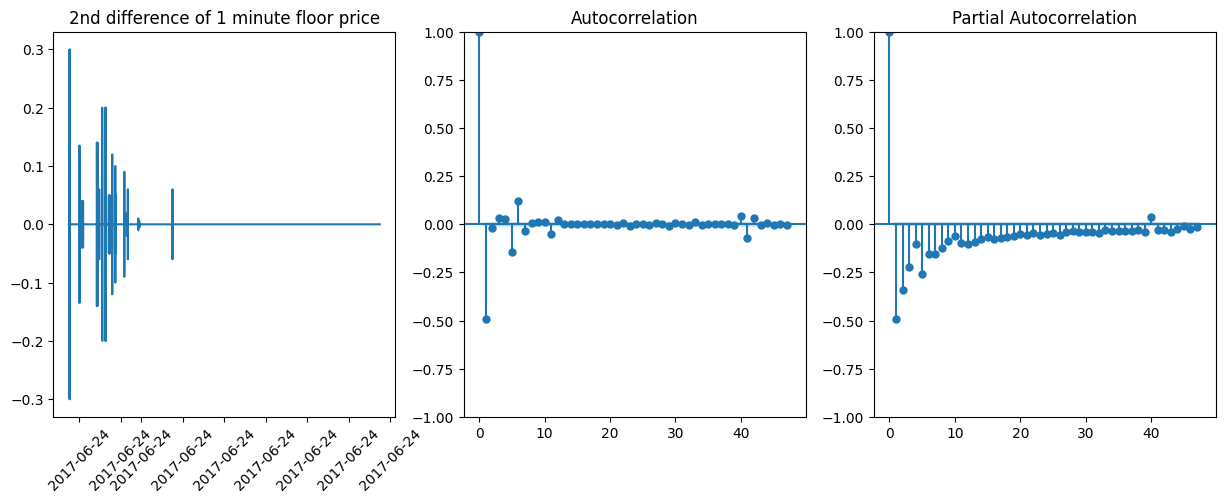

In [106]:
## Original floor price
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,5))
diff0 = df['price']
axes[0].plot(diff0); axes[0].set_title('Original 1 minute floor price')
axes[0].set_xticklabels(diff0.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)
plot_acf(diff0.dropna(), ax=axes[1])
axes[1].axis(xmin=-2, xmax=28)
plot_pacf(diff0.dropna(), ax=axes[2])
axes[2].axis(xmin=-2, xmax=28)
plt.show()
## 1st diff
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,5))
diff1 = df['price'].diff()
axes[0].plot(diff1); axes[0].set_title('1st difference of 1 minute floor price')
axes[0].set_xticklabels(diff1.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)
plot_acf(diff1.dropna(), ax=axes[ 1])
axes[1].axis(xmin=-2, xmax=28)
plot_pacf(diff1.dropna(), ax=axes[ 2])
axes[2].axis(xmin=-2, xmax=28)
plt.show()

## 2nd diff
fig, axes = plt.subplots(1, 3, sharex=False, figsize=(15,5))
diff2 = df['price'].diff().diff()
axes[0].plot(diff2); axes[0].set_title('2nd difference of 1 minute floor price')
axes[0].set_xticklabels(diff2.reset_index()['date_time'].dt.strftime("%Y-%m-%d"), rotation=45)
plot_acf(diff2.dropna(), ax=axes[ 1])
plot_pacf(diff2.dropna(), ax=axes[2])
plt.show()

1st difference looks promising

No difference suggests model ARMA(1,1) or ARIMA(1,0,1)

# Is timeseries random walk?

Augmented Dickey–Fuller test

The ADF test examines the null hypothesis that a time series has a unit root, which is a characteristic of a random walk. If the null hypothesis is not rejected, it suggests the time series is a random walk.

### No diff

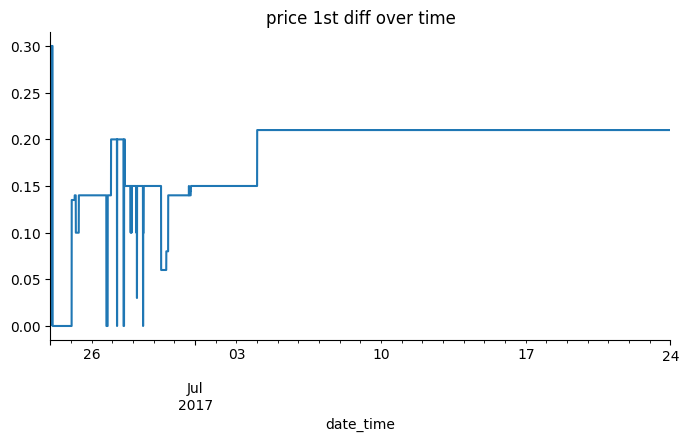

In [113]:
df['price'].plot(kind='line', figsize=(8, 4), title='price 1st diff over time')
plt.gca().spines[['top', 'right']].set_visible(False)

In [114]:
test = adfuller(df.dropna(), autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)

Test Statistic                    -5.054290
p-value                            0.000017
#Lags                             54.000000
Number of Observations Used    43142.000000
Critical Value (1%)               -3.430502
Critical Value (5%)               -2.861607
Critical Value (10%)              -2.566806
dtype: float64


The critical value (1%) is -3.43 and the test statistic is smaller (-5.05) than it, which means we can assume the target series is stationary with high probability

## 1st diff

In [108]:
df_1stdiff = df.diff()

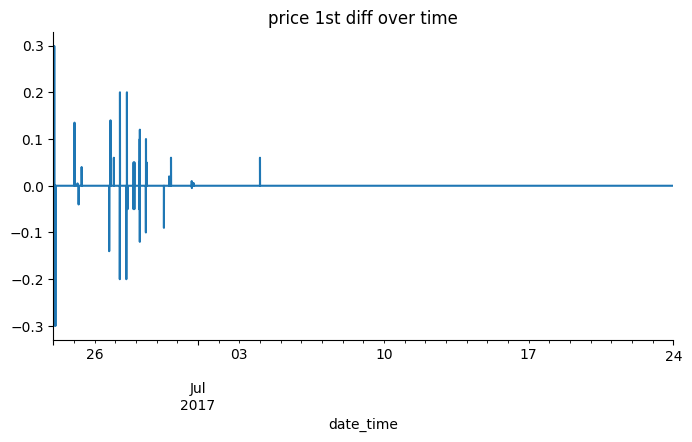

In [111]:
df_1stdiff['price'].plot(kind='line', figsize=(8, 4), title='price 1st diff over time')
plt.gca().spines[['top', 'right']].set_visible(False)

In [112]:
test = adfuller(df_1stdiff.dropna(), autolag='AIC')
output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags','Number of Observations Used'])
for k,v in test[4].items():
    output['Critical Value (%s)'%k] = v
print(output)

Test Statistic                   -33.301435
p-value                            0.000000
#Lags                             55.000000
Number of Observations Used    43140.000000
Critical Value (1%)               -3.430502
Critical Value (5%)               -2.861607
Critical Value (10%)              -2.566806
dtype: float64


autolag='AIC': This setting tells the adfuller function to use the Akaike Information Criterion (AIC) to automatically choose the number of lags to include in the regression. The AIC is a statistical criterion used for model selection. It balances the goodness of fit with the complexity of the model. In the context of the ADF test, it selects the lag order that minimizes the AIC, indicating the number of lags that provide a good balance between capturing auto-correlation and avoiding model overfitting.

The critical value (1%) is -3.43 and the test statistic is much smaller than it, which means we can assume the target series is stationary with high probability

**Lack of variability - affects ADF highly!**

# Original timeseries is stationary - first experiment with arima d=0/arma with org ts

### ARIMA test

In [118]:
n_splits = 5  # Number of splits for time series cross-validation
              # relatively small number, so that even though there is not much sudden shifts they will be captured
tscv = TimeSeriesSplit(n_splits=n_splits)
val = df.reset_index()['price']

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


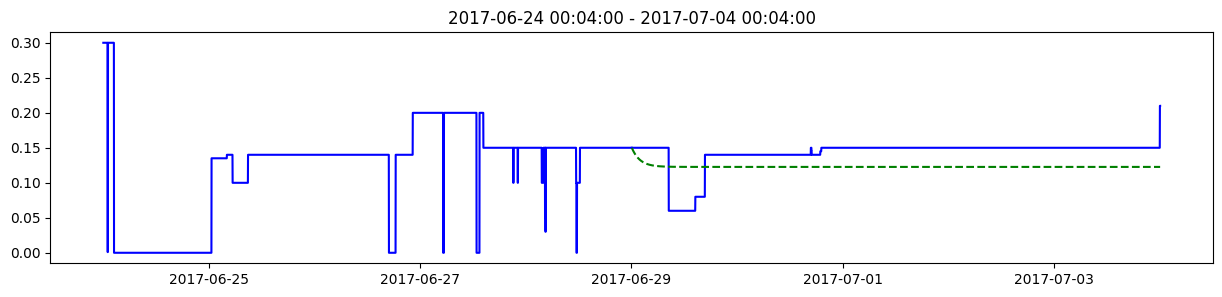

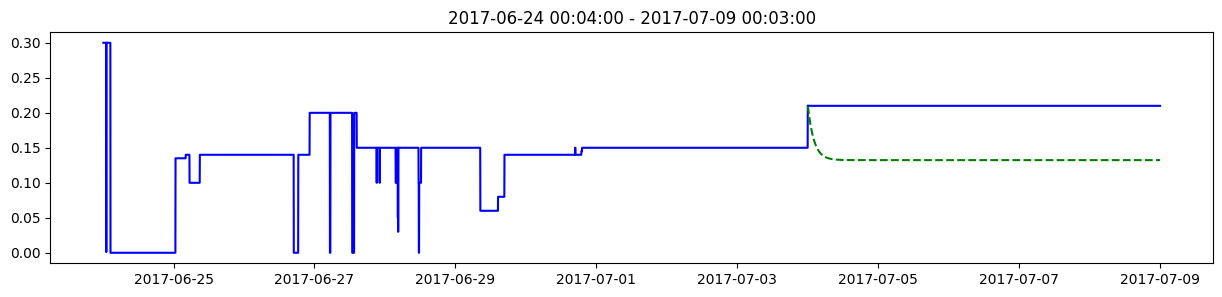

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


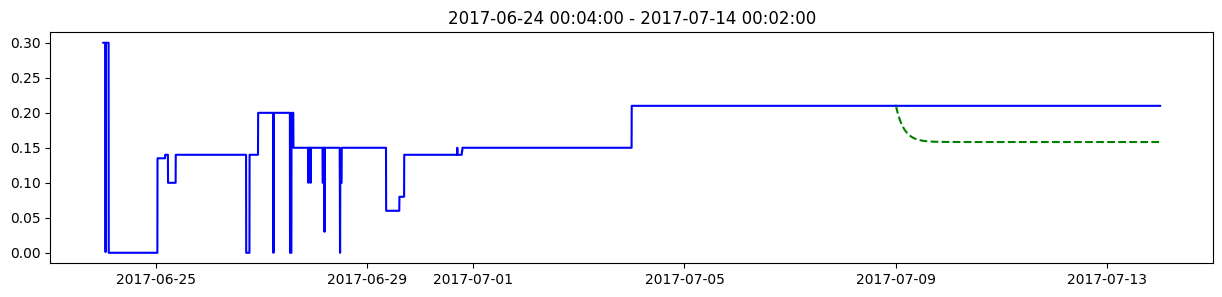

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


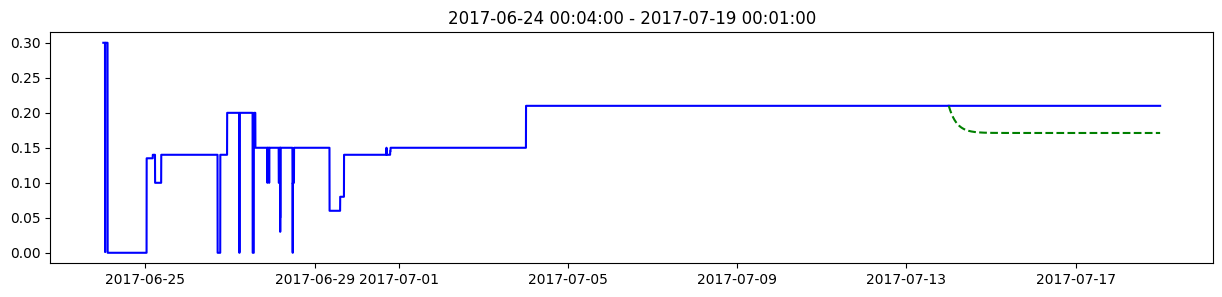

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


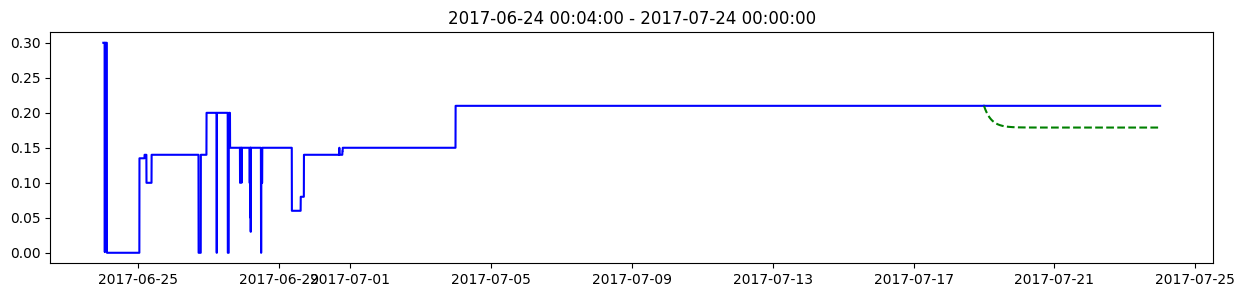

In [132]:
crossval_id = 0
arima_metrics = {}
for train_index, test_index in tscv.split(df):
    train_data = val[train_index]
    test_data = val[test_index]
    model = ARIMA(train_data, order=(1,0,1))
    model_fit = model.fit()
    predictions = model_fit.forecast(steps=len(test_data))

    fig, ax = plt.subplots(figsize=(15,3))
    tmp = df.reset_index().copy()
    tmp['train'] = train_data
    tmp['test'] = test_data
    tmp['pred'] = predictions
    tmp = tmp.set_index('date_time')

    ax.plot(tmp['train'], color='blue')
    ax.plot(tmp['test'], color='blue')
    ax.plot(tmp['pred'], color='green', linestyle='dashed')
    plt.title("2017-06-24 00:04:00 - " + str(tmp.dropna(subset=['pred']).reset_index()['date_time'].dt.strftime("%Y-%m-%d %H:%M:%S").iloc[-1]))
    plt.show()

    metrics = {}
    metrics['aic'] = model_fit.aic
    metrics['mse'] = mean_squared_error(test_data, predictions)
    metrics['mae'] = mean_absolute_error(test_data, predictions)
    metrics['mape'] = mean_absolute_percentage_error(test_data, predictions)
    arima_metrics[crossval_id] = metrics
    crossval_id += 1


In [140]:
arima_metrics_df = pd.DataFrame.from_dict(arima_metrics, orient='index')
arima_metrics_df

,aic,mse,mae,mape
0,-47414.078263,0.000818,0.026854,0.216780
1,-104407.625033,0.005864,0.076248,0.363155
2,-165333.284959,0.002554,0.050157,0.238886
3,-228715.273903,0.001422,0.037361,0.177944
4,-293917.877831,0.000904,0.029765,0.141765


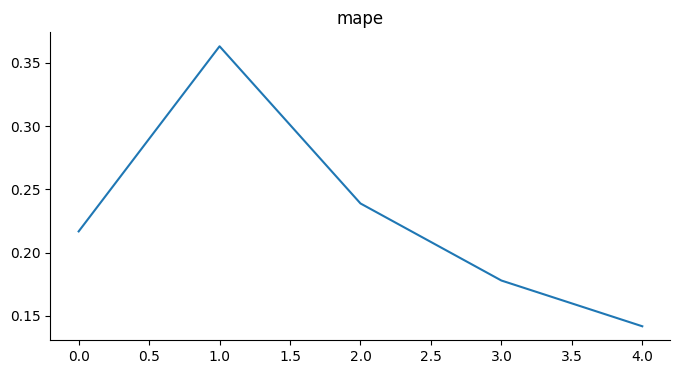

In [136]:
arima_metrics_df['mape'].plot(kind='line', figsize=(8, 4), title='mape')
plt.gca().spines[['top', 'right']].set_visible(False)

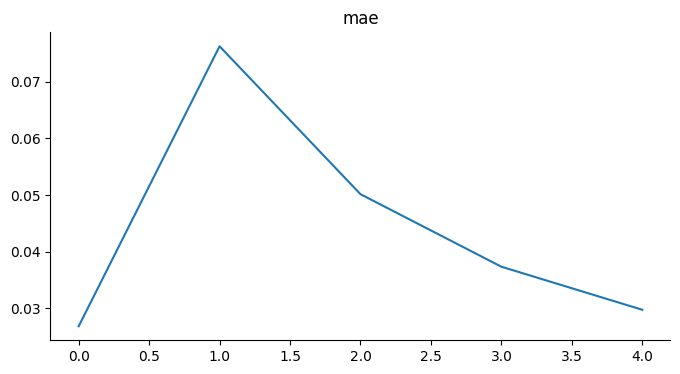

In [137]:
arima_metrics_df['mae'].plot(kind='line', figsize=(8, 4), title='mae')
plt.gca().spines[['top', 'right']].set_visible(False)

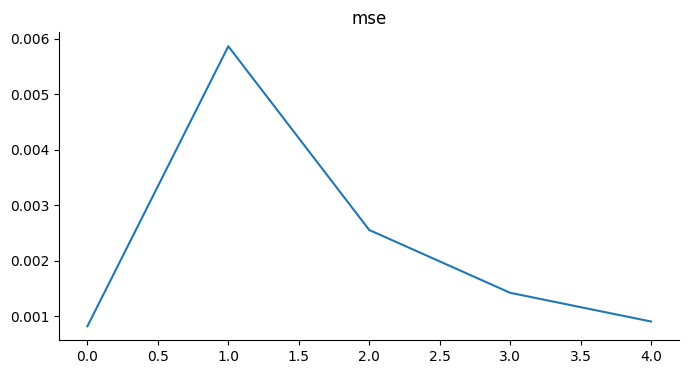

In [138]:
arima_metrics_df['mse'].plot(kind='line', figsize=(8, 4), title='mse')
plt.gca().spines[['top', 'right']].set_visible(False)

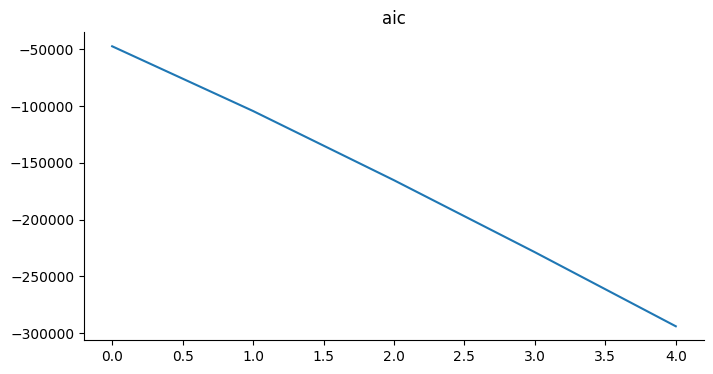

In [139]:
arima_metrics_df['aic'].plot(kind='line', figsize=(8, 4), title='aic')
plt.gca().spines[['top', 'right']].set_visible(False)